# Logisitic Regression Fitting - GPU
This 

In [14]:
import os
import pyopencl as pcl
import numpy as np
import scipy.stats as ss
import pandas as pd
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [19]:
# let's try to find available devices
platforms = pcl.get_platforms()
for p in platforms:
    devs = p.get_devices()
    for d in devs:
        print("#"*10)
        print()
        print('name:', d.name)
        print('device type:', pcl.device_type.to_string(d.type))
        print('global memory size: ', d.global_mem_size / (1024**3), 'GB')
        print()
        

            

##########

name: Intel(R) Core(TM) i7-4870HQ CPU @ 2.50GHz
device type: CPU
global memory size:  16.0 GB

##########

name: Iris Pro
device type: GPU
global memory size:  1.5 GB

##########

name: AMD Radeon R9 M370X Compute Engine
device type: GPU
global memory size:  2.0 GB



In [2]:
# as before set up the data
x0_1 = ss.norm(loc=10.0, scale=2.0)
x0_0 = ss.norm(loc=7.0, scale=2.0)
x1_1 = ss.norm(loc=5.0, scale=3.0)
x1_0 = ss.norm(loc=-5.0, scale=3.0)

nsamps=1024

X_1 = pd.DataFrame(index=range(nsamps), 
                   columns=['x0','x1', 'y'])
X_0 = pd.DataFrame(index=range(nsamps), 
                   columns=['x0','x1', 'y'])

X_1.loc[:, 'x0'] = x0_1.rvs(size=(nsamps,)).astype(np.float32)
X_1.loc[:, 'x1'] = x1_1.rvs(size=(nsamps,)).astype(np.float32)
X_1.loc[:, 'y'] = np.ones(shape=(nsamps,)).astype(np.float32)

X_0.loc[:, 'x0'] = x0_0.rvs(size=(nsamps,)).astype(np.float32)
X_0.loc[:, 'x1'] = x1_0.rvs(size=(nsamps,)).astype(np.float32)
X_0.loc[:, 'y'] = np.zeros(shape=(nsamps,)).astype(np.float32)


X_all = pd.concat((X_1, X_0), ignore_index=True)

X_all = X_all.reindex(np.random.permutation(X_all.index))

X = X_all.loc[:, ['x0', 'x1']]
y = X_all.loc[:,'y']

In [3]:
# we need to provide the path to the OpenCL file with our code
clfile = os.path.join('..','src','glm_gpu','cl','logistic.cl')
os.path.isfile(clfile)

True

In [4]:
os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1'
# here I get the device I want, which is the AMD Radeon card
device = pcl.get_platforms()[0].get_devices()[2]
# we create a context and attach the device to it
cntx = pcl.Context([device])
# and we create a queue and attach it to the context
queue = pcl.CommandQueue(cntx)


with open(clfile, 'r') as f:
    # here, we read in the OpenCL code as a string and build the program
    # all of the kernels in this file will now be stored in the 'programs' object
    programs = pcl.Program(cntx, f.read()).build()
    # print out the code so we can see it here
    f.seek(0,0)
    print(f.read())



inline float dotproduct(__global float * a, __global float * b, const int size)
{
  float out = 0.0f;
  for(int i = 0; i < size; i++){
    out += a[i] * b[i];
  }
  return out;
}

inline float sigmoid(__global float * X, __global float * theta, int row_id, int nrows, int ncols)
{
  float linear_sum = 0.0f;
  for(int j = 0; j < ncols; j++){
    linear_sum += (X[row_id + j*nrows] * theta[j]);
  }

  float exponential = pow(M_E_F, -linear_sum);
  exponential += 1.0f;
  float sig = 1.0f / exponential;
  return sig;
}

__kernel void matrix_row_mean(__global float * in, __global float * out, __local float * scratch, const int nrows, const int ncols)
{
  int gid = get_global_id(0);
  int lid = get_local_id(0);
  int global_size = get_global_size(0);

  // first step is a sequential loop
  for(int j = 0; j < ncols; j++){
    float accum = 0.0f;
    while(gid < nrows){
      accum += in[gid*ncols + j];
      gid += global_size;
    }
    scratch[lid*ncols + j] = accum;
  }


  // now do a par

In [28]:
for k in programs.all_kernels():
    print(k.function_name)

matrix_row_mean
sig
logistic_cost_ols
logistic_gradient_ols
logisitc_prediction
logistic_update_ols


In [8]:
# for the sake of getting this to work, I initally implemented the sum of square error as the cost function
# I can update that with the canonical logistic regression cost function later
def fit_gpu(X, y, theta, queue, cntx):
    # set up some parameters we will need for each iteration
    tol = 1e-5
    learning_rate = 1e-2
    nrows = np.int32(X.shape[0])
    ncols = np.int32(X.shape[1])
    costs = []
    for i in range(0, 1000):
        # here we set up the array to hold the cost values on the host.
        # in this case, we will compute the cost of each sample individually, copy data back to the host and 
        # do the final averaging on the host
        cost_arr = np.zeros(shape=(X.shape[0],), dtype=np.float32)
        
        # next let's set up the buffers between our data that is in host memory and device memory
        X_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=X)
        y_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=y)
        theta_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=theta)
        cost_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_WRITE | pcl.mem_flags.COPY_HOST_PTR, hostbuf=cost_arr)
        
        # ok, now we set up the kernel for executing the cost function on the GPU
        cost_event = programs.logistic_cost_ols(queue, # the queue to attach this kernel to
                                                X.shape,# this is the global work size on the GPU. note that this is not optimal
                                                None, # this is the local work size on the GPU. by leaving it as None, OpenCL will decide for us
                                                X_buf, # arg 1 of the cost kernel
                                                theta_buf, # arg 2 of the cost kernel
                                                y_buf, # arg 3 of the cost kernel
                                                cost_buf, # arg 4 of the cost kernel
                                                nrows, # arg 5 of the cost kernel
                                                ncols) # arg 6 of the cost kernel
        
        
        # let's make sure it finishes executing
        cost_event.wait()
        # now that it's done, copy the data back to the host
        pcl.enqueue_copy(queue, cost_arr, cost_buf)
        # finish averaging on the host using python
        cost_arr = cost_arr.sum()
        cost_arr /= 2.
        costs.append(cost_arr)
        if cost_arr < tol:
            break
        else:
            # the workflow for executing and updating the data for the gradient is similar to the above code.
            # see if you can follow along!
            grad_buf = pcl.Buffer(cntx, pcl.mem_flags.WRITE_ONLY , size=X.nbytes)
            grad_event = programs.logistic_gradient_ols(queue,X.shape,None,X_buf,theta_buf,y_buf,grad_buf,nrows,ncols)
            grad_event.wait()
            grad_arr = np.zeros(shape=X.shape, dtype=np.float32)
            pcl.enqueue_copy(queue, grad_arr, grad_buf)
            grad_arr = grad_arr.mean(axis=0)
            theta = theta + learning_rate * grad_arr
            
    return theta, costs

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)
new_t = np.random.normal(size=theta.shape).astype(np.float32)
fitted_t_gpu, costs_gpu = fit_gpu(X_train.values, y_train.values, new_t, queue, cntx)

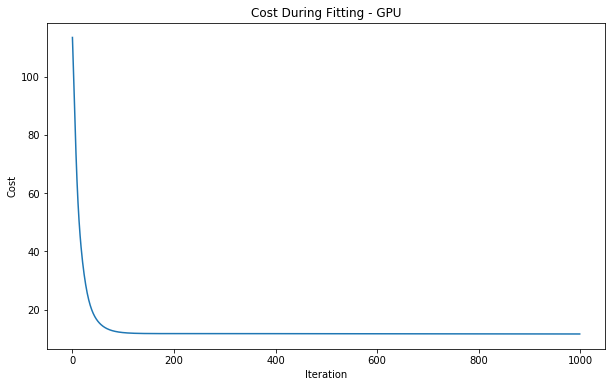

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(costs_gpu)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title("Cost During Fitting - GPU")
plt.show()

In [20]:
print(fitted_t_gpu)

[ 0.00917345  1.27897406]
